# Document Image Classification - Exploratory Data Analysis

This notebook explores the document image classification dataset, which consists of:
- Images (TIF format)
- OCR text data (TXT files)

The goal is to understand the characteristics of the data before building our models.

In [1]:
# Import necessary libraries
import os, glob, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
from nltk.corpus import stopwords

# Configure plots
plt.style.use('seaborn-v0_8')
%matplotlib inline
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Data Loading

First, let's locate our data directories and check the structure.

In [2]:
# Define paths to data directories
base_dir = os.path.join('..', 'data')  # Relative to this notebook
image_dir = os.path.join(base_dir, 'images')
ocr_dir = os.path.join(base_dir, 'ocr')

# Check that directories exist
print(f"Image directory exists: {os.path.exists(image_dir)}")
print(f"OCR directory exists: {os.path.exists(ocr_dir)}")

# List classes (subdirectories)
image_classes = sorted([d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))])
ocr_classes = sorted([d for d in os.listdir(ocr_dir) if os.path.isdir(os.path.join(ocr_dir, d))])

print(f"\nImage classes: {image_classes}")
print(f"OCR classes: {ocr_classes}")


Image directory exists: True
OCR directory exists: True

Image classes: ['0', '2', '4', '6', '9']
OCR classes: ['0', '2', '4', '6', '9']


## 2. Data Distribution

Let's check how many files we have for each class.

In [3]:
# Count files per class
image_counts = {cls: len(glob.glob(os.path.join(image_dir, cls, '*.TIF'))) for cls in image_classes}
ocr_counts = {cls: len(glob.glob(os.path.join(ocr_dir, cls, '*.TIF.txt'))) for cls in ocr_classes}

# Combine and display
counts_df = pd.DataFrame({
    'Class': list(image_counts.keys()),
    'Image Count': list(image_counts.values()),
    'OCR Count': [ocr_counts.get(cls, 0) for cls in image_counts.keys()]
})
display(counts_df)

# Check for mismatches
mismatch = counts_df[counts_df['Image Count'] != counts_df['OCR Count']]
if mismatch.empty:
    print("No mismatches found - all classes have equal numbers of image and OCR files.")
else:
    print("Mismatches detected:")
    display(mismatch)


,Class,Image Count,OCR Count
0,0,500,500
1,2,500,500
2,4,500,500
3,6,500,500
4,9,500,500


No mismatches found - all classes have equal numbers of image and OCR files.


## 3. Sample Loading

Let's load a few samples from each class to examine them.

In [4]:
def load_samples(num_per_class=5):
    samples = []
    for cls in image_classes:
        image_files = glob.glob(os.path.join(image_dir, cls, '*.TIF'))[:num_per_class]
        for img_path in image_files:
            basename = os.path.basename(img_path)
            ocr_path = os.path.join(ocr_dir, cls, basename + '.txt')
            ocr_text = None
            if os.path.exists(ocr_path):
                with open(ocr_path, 'r', encoding='utf-8', errors='ignore') as f:
                    ocr_text = f.read()
            samples.append({'class': cls, 'image_path': img_path, 'ocr_text': ocr_text})
    return pd.DataFrame(samples)

samples_df = load_samples()
print(f"Loaded {len(samples_df)} samples across {len(samples_df['class'].unique())} classes")
samples_df.head()


Loaded 25 samples across 5 classes


,class,image_path,ocr_text
0,0,../data/images/0/cdac0414-e5c0-409d-b397-f4552...,"\n\n \n\n“Clem Ban ips Cow,\n\n1693 ot yt oe\..."
1,0,../data/images/0/77befd48-9f17-405b-9a0a-66a66...,"\n\nCORROON & BLACK COMPANY OF NEW YORK, INC...."
2,0,../data/images/0/b58f3dde-75cd-4a77-ad28-2fbb9...,"\n\nPHILIP MORRIS\n\nRESEARCH CENTER, RICHMON..."
3,0,../data/images/0/60d1fe91-219a-49db-a3c1-d1f4d...,"\n\n \n\nSeptenber 2, 1982\n\nHrs J. A. Johen..."
4,0,../data/images/0/0849fc29-99d4-4b81-a1e9-fb0ca...,\n\n \n\nTHE TOBACCO INSTITUTE\n\n1475 1 STRE...


## 4. Image Analysis

Let's analyze the characteristics of our image data.

       height       width  channels
count    25.0   25.000000      25.0
mean   1000.0  753.240000       1.0
std       0.0   48.387567       0.0
min    1000.0  611.000000       1.0
25%    1000.0  754.000000       1.0
50%    1000.0  754.000000       1.0
75%    1000.0  771.000000       1.0
max    1000.0  864.000000       1.0


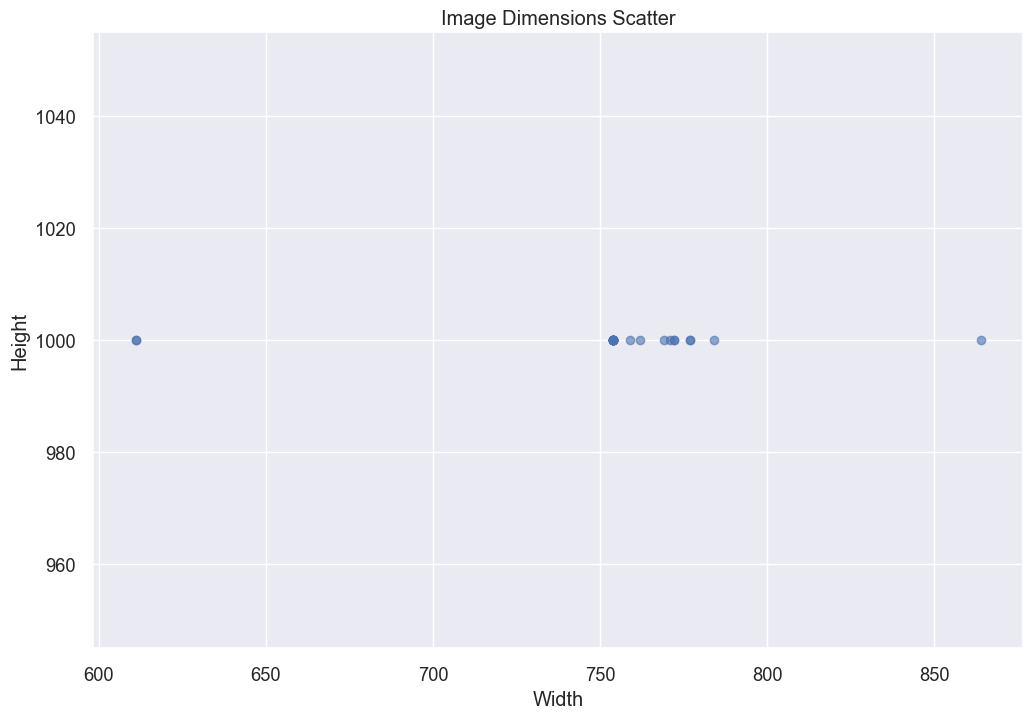

In [5]:
def analyze_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    h, w = img.shape[:2]
    channels = 1 if len(img.shape) == 2 else img.shape[2]
    return h, w, channels

stats = samples_df['image_path'].apply(lambda p: pd.Series(analyze_image(p), index=['height', 'width', 'channels']))
samples_df = pd.concat([samples_df, stats], axis=1)

print(samples_df[['height', 'width', 'channels']].describe())

plt.scatter(samples_df['width'], samples_df['height'], alpha=0.6)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Dimensions Scatter')
plt.show()


## 5. Text Analysis

Now let's examine the OCR text data.

       text_length  word_count
count     25.00000   25.000000
mean    1417.16000  226.120000
std     1568.08691  259.348434
min        3.00000    0.000000
25%      109.00000   18.000000
50%      901.00000  144.000000
75%     2364.00000  366.000000
max     5508.00000  908.000000


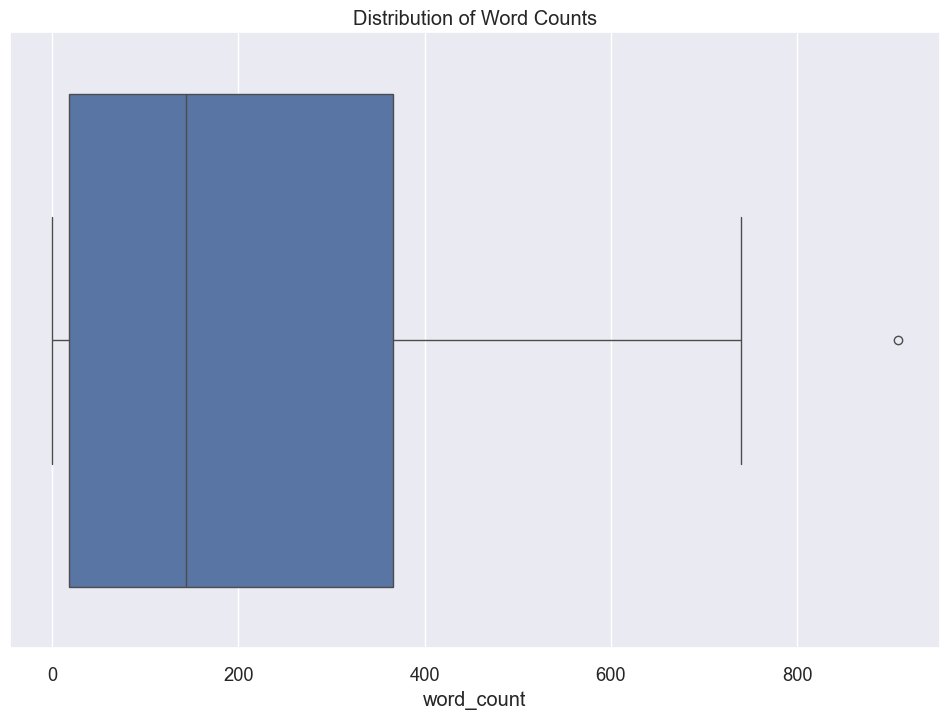

In [6]:
samples_df['text_length'] = samples_df['ocr_text'].apply(lambda x: len(x) if x else 0)
samples_df['word_count'] = samples_df['ocr_text'].apply(lambda x: len(x.split()) if x else 0)

print(samples_df[['text_length', 'word_count']].describe())

sns.boxplot(x='word_count', data=samples_df)
plt.title('Distribution of Word Counts')
plt.show()


Let's look at the most common words in each class.

In [7]:
def get_common_words(texts, n=20):
    words = re.sub(r'[^a-zA-Z\s]', '', texts.lower()).split()
    stop_words = set(stopwords.words('english'))
    filtered = [w for w in words if w not in stop_words and len(w) > 1]
    return Counter(filtered).most_common(n)

for cls in samples_df['class'].unique():
    all_text = ' '.join(samples_df[samples_df['class'] == cls]['ocr_text'].dropna())
    print(f"\nMost common words for class {cls}:")
    for word, count in get_common_words(all_text):
        print(f"{word}: {count}")



Most common words for class 0:
october: 7
new: 6
york: 5
mr: 5
cgl: 5
section: 5
revised: 5
exhibit: 5
crop: 5
philip: 4
morris: 4
please: 4
loss: 4
room: 4
vice: 4
president: 4
grade: 4
ban: 3
street: 3
ny: 3

Most common words for class 2:
subject: 4
pm: 3
military: 3
rick: 3
mike: 2
bogusta: 2
marlboro: 2
james: 2
kathleen: 2
michelle: 2
smith: 2
ann: 2
sorry: 2
cassette: 2
dont: 2
great: 2
mary: 2
denise: 2
michael: 2
mark: 2

Most common words for class 4:
trothtcten: 1
vehicle: 1
recommend: 1
answer: 1
fo: 1
bch: 1

Most common words for class 6:
smoke: 24
cigarette: 16
tobacco: 13
sv: 9
research: 8
ae: 8
nicotine: 8
subfractions: 7
new: 7
smoking: 7
compounds: 7
york: 6
usa: 6
ss: 6
filtration: 6
filter: 6
compound: 6
tpm: 6
analysis: 5
te: 5

Most common words for class 9:
tobacco: 20
smoking: 16
smokers: 15
north: 13
carolina: 9
cigarettes: 9
year: 9
ing: 7
million: 7
cigarette: 7
new: 7
people: 7
accidents: 6
milion: 6
pounds: 6
last: 6
also: 6
project: 6
state: 5
county: 5


## 6. Further Analysis and Next Steps

Fill in observations here after running exploratory steps.